# LAB 5: Reconstructing galaxy images with compressed sensing
In this lab, you will implement a **compressed sensing** method, namely the **iterative soft thresholding algorithm (ISTA)**, and use it to reconstruct **DESI Legacy Imaging
Surveys (DECals)** images of spiral galaxies (see Lab 3) from sparse and noisy measurements. ISTA iteratively minimizes the **Lasso optimization problem** that we considered in the lecture. We will provide a brief introduction of the ideas behind ISTA as we go. Some of the code has already been filled in for you; simply add your code (and you answers) wherever you find a "**TODO**" tag. If you prefer working with Python scripts rather than a Jupyter notebook, you can of course copy-paste the content of this notebook to a Python script (or simply run the command ```jupyter nbconvert --to script [NOTEBOOK].ipynb```).

GET DATASET : https://drive.google.com/file/d/1MsuY-TTw2duDt8ZirMfDdhHgDslSjxVS/view?usp=share_link

## Loading, inspecting, and preparing the data

In [323]:
import os
import numpy as np
from scipy import fftpack
from scipy import linalg
import h5py
import pywt
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'turbo'
np.random.seed(1111)

**TODO**: Load the data from 'DECals_galaxies.hdf5' (same data as in Lab 3). The data has shape 256 x 256 x 256 x 3, namely 256 spiral galaxy images of size 256 x 256 pixels with 3 channels (g, r, and z band).

In [324]:
with h5py.File('/Users/harshitlakum/Desktop/DECals_galaxies.hdf5') as F:
    images = np.array( F['images_spirals'] )

**TODO**: Select your favourite galaxy image and take the average over the three channels (index 1 is a nice one for example). We will only need a single image in this lab, but you can of course re-run the Jupyter notebook for another galaxy image.

In [325]:
# Calculate the average over the last axis (channels)
average_dataset = np.mean(images, axis=-1)

# Select the 25th image from the averaged dataset
X_orig = average_dataset[25]



**TODO**: Plot the galaxy image $\mathbf{X}_{orig}$.

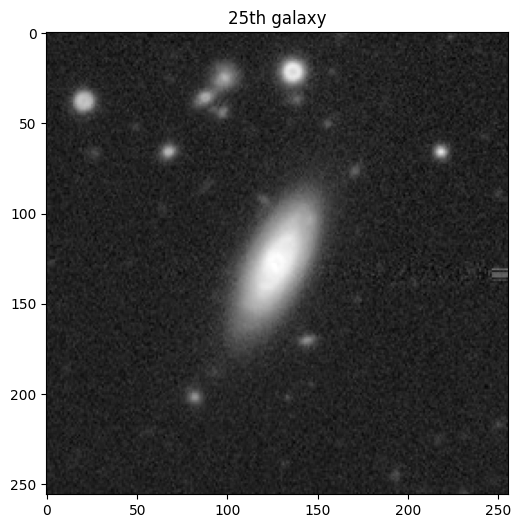

In [326]:
# Plot the galaxy image
plt.figure(figsize=(6, 6))
plt.imshow(X_orig, cmap='gray')
plt.title('25th galaxy')
plt.show()

In [327]:
# Store the shape (2D and flattened as 1D)
shape = X_orig.shape
D = np.prod(shape)


In [328]:
# Print the minimum and maximum pixels values
print(X_orig.min(), X_orig.max())

1.0 233.66666666666666


**TODO**: Add some Gaussian (artificial) measurement noise to the data (independently drawn in each pixel), with zero mean and standard deviation $\sigma = 10$.

In [329]:
# Generate Gaussian noise
mean = 0  # mean of the Gaussian noise
std_dev = 10  # standard deviation of the Gaussian noise
gaussian_noise = np.random.normal(mean, std_dev, X_orig.shape)


X_noisy_raw = X_orig + gaussian_noise


**TODO**: We need to make sure the pixel values stay in the range [0, 255]. Create a function that clips pixel values outside the range `[low, high]` and sets them to the boundary values `low` and `high`, respectively.

In [330]:
def clip_vals(x, low = 0, high = 255):
    clipped_data = np.clip(x, low, high)
    return clipped_data

    

**TODO**: Apply this function to the noisy data.

In [331]:
X_noisy = clip_vals(X_noisy_raw)


**TODO**: Plot the noisy galaxy image $\mathbf{X}_{noisy}$.

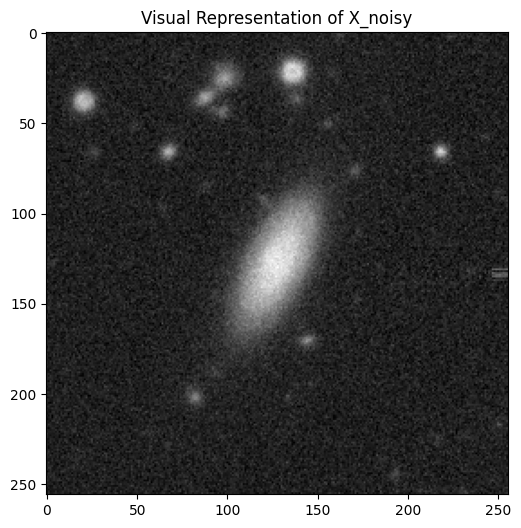

In [332]:

# Plotting the image
plt.figure(figsize=(6, 6))
plt.imshow(X_noisy, cmap='gray')  # Use a grayscale colormap and set the color range
plt.title('Visual Representation of X_noisy')
plt.show()

We will now randomly subsample pixel values in the noisy galaxy image $\mathbf{X}_{noisy}$, yielding an image $\mathbf{Y}$ containing much fewer values (and zeros everywhere else) and then try to reconstruct the original image $\mathbf{X}_{orig}$ by iteratively solving a regularized minimization problem as considered in the lecture.

**TODO**: Generate a new image $\mathbf{Y}$ by randomly selecting 5% of the pixel values in $\mathbf{X}_{noisy}$ that will be kept and setting the remaining 95% of the pixel values in $\mathbf{Y}$ to 0 (in such a way that each pixel in $\mathbf{X}_{noisy}$ has the same probability of being kept). You can do this for example by defining a random mask (array containing booleans True/False with the same shape as $\mathbf{X}_{noisy}$) that is `True` whenever a value shall be kept and `False` else. Also print out the number of pixels in $\mathbf{X}_{noisy}$ and the number of subsampled pixels in $\mathbf{Y}$.

*NOTE*: In the lecture, we defined the subsampled vector $\mathbf{y}$ to have dimension $S \ll D$. Since we are dealing with images here, it will be convenient to use the same shape for the subsampled picture $\mathbf{Y}$ as for the original picture $\mathbf{X}_{orig}$, so the subsampled picture can be plotted (which would not be possible with a flattened 1D vector of length $S$). The information about the pixels contained in the subsampled set is provided in the mask, and $\mathbf{Y} = 0$ wherever `mask == False`.

In [333]:
# Generate subsampled picture Y
 # X_noisy is already defined and contains the noisy image data
probability_of_keeping = 0.05  # 5% chance of keeping a pixel



mask = np.random.rand(*X_noisy.shape) < probability_of_keeping
Y =  np.where(mask, X_noisy, 0)

print("X noisy pixels:", X_noisy.size)
print("Y noisy pixels:", Y.size)

X noisy pixels: 65536
Y noisy pixels: 65536


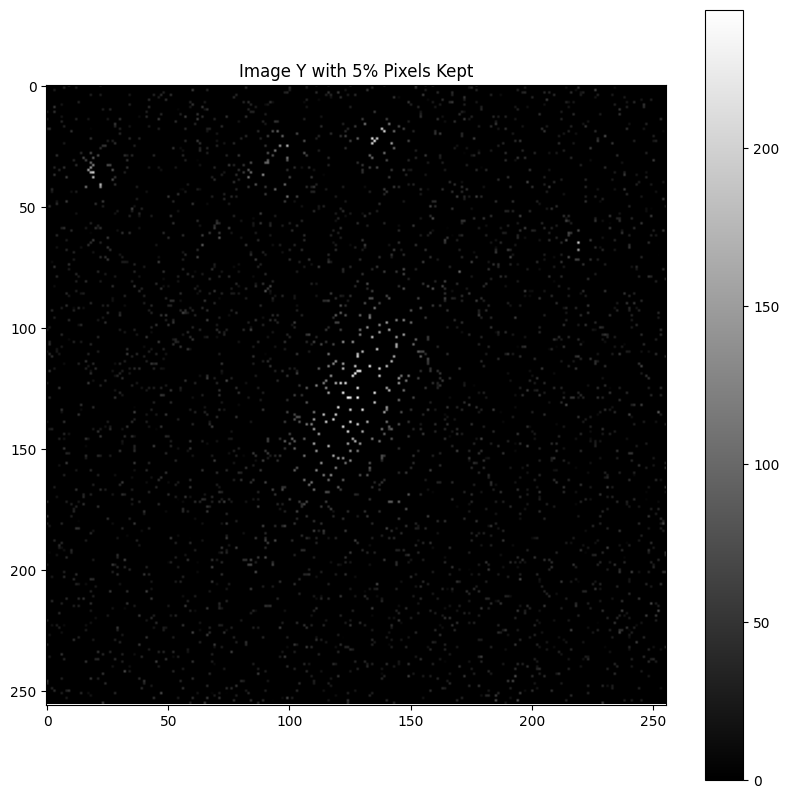

In [334]:
# Plot of the subsampled image
# Display the result using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(Y, cmap='gray')
plt.title('Image Y with 5% Pixels Kept')
plt.colorbar()
plt.show()

## Discrete cosine transform and discrete wavelet transform
The basis classes DCT and DWT are ready to be used - no need to do anything here.

In [335]:
class DCT:
    """Discrete cosine transform"""

    def __init__(self, shape):
        """
        Initialize discrete cosine transform.
        :param shape: image shape
        """
        self.shape = shape

    def forward(self, image):
        """
        Forward DCT
        :param image: 2D array
        :return cosine-transformed image
        """
        image_t = fftpack.dct(fftpack.dct(image, norm='ortho', axis=0), norm='ortho', axis=1)
        return image_t.reshape(-1)

    def inverse(self, image_t):
        """
        Inverse DCT
        :param image_t: cosine-transformed image
        :return image in real space
        """
        image_t = image_t.reshape(self.shape)
        return fftpack.idct(fftpack.idct(image_t, norm='ortho', axis=0), norm='ortho', axis=1)

In [336]:
class DWT:
    """Discrete wavelet transform"""

    def __init__(self, shape, wavelet='db4', level=3, do_weighting=True):
        """
        Initialize discrete wavelet transform.
        :param shape: image shape
        :param wavelet: name of the wavelet
        :param level: level of hierarchical wavelet analysis
        :param do_weighting: if True: weight deeper levels more
        """
        self.shape = shape
        self.wavelet = wavelet
        self.level = level
        self.mat_shapes = []

        # Weight the coefficients
        if do_weighting is False:
            self.weights = np.ones(3 * self.level + 1)
        else:
            weights = np.linspace(1, .2, self.level)
            weights = np.repeat(weights, 3)
            weights = np.hstack([[20], weights])  # insert first coefficient
            self.weights = weights

    def forward(self, image):
        """
        Forward DWT
        :param image: 2D array
        :return list with all wavelet coefficients (for all levels)
        """
        coeffs = pywt.wavedec2(image, wavelet=self.wavelet, level=self.level)
        # format: [cAn, (cHn, cVn, cDn), ...,(cH1, cV1, cD1)] , n=level

        # Transform to a list of arrays
        mat_list = [coeffs[0]]
        mat_list += [c_mat for c in coeffs[1:] for c_mat in c]

        # Store all matrix shapes
        self.mat_shapes = list(map(np.shape, mat_list))

        # Store coefficent matrices as list of arrays and apply weighting
        vec_list = [np.asarray(mat_list[j]).flatten() * self.weights[j] for j in range(3 * self.level + 1)]

        # Return a long list with all coefficients
        return np.concatenate(vec_list)

    def inverse(self, wavelet_vector):
        """
        Inverse DWT
        :param wavelet_vector: long list with all wavelet coefficients (output of forward)
        :return reconstructed image
        """
        # forward must be called at least once before calling inv
        if len(self.mat_shapes) == 0:
            print("Call 'forward' first to set the shapes of coefficient matrices!")
            return []

        # Define a list with the matrix shapes
        vec_shapes = list(map(np.prod, self.mat_shapes))

        # Split up the 1D wavelet array into a list of arrays (one for each coefficient)
        split_indices = np.cumsum(vec_shapes)
        vec_list_weighted = np.split(wavelet_vector, split_indices)

        # Revert weighting
        vec_list = [vec_list_weighted[j] / self.weights[j] for j in range(3 * self.level + 1)]

        # Transform back to level-wise format
        coeffs = [np.reshape(vec_list[0], self.mat_shapes[0])]
        for j in range(self.level):
            triple = vec_list[3 * j + 1:3 * (j + 1) + 1]
            triple = [np.reshape(triple[i], self.mat_shapes[1 + 3 * j + i]) for i in range(3)]
            coeffs = coeffs + [tuple(triple)]

        # Return the reconstructed image
        return pywt.waverec2(coeffs, wavelet=self.wavelet)

## Some background on ISTA
In order to reconstruct the image $\mathbf{X}_{orig}$, consider again the **Lasso optimization problem** in the lecture notes for the task of compressed sensing
$$
    \boldsymbol{\theta}^\star = \text{argmin}_{\boldsymbol{\theta}} \ \|\mathbf{y} - \boldsymbol{\Phi} \boldsymbol{\theta}\|_2^2 + \lambda \|\boldsymbol{\theta}\|_1
                             =: \text{argmin}_{\boldsymbol{\theta}} \ F(\boldsymbol{\theta}) + \lambda G(\boldsymbol{\theta}),
$$
where $\mathbf{y} = \text{flatten}(\mathbf{Y})$ (or, equivalently, the quantities can be left as matrices, in which case the Euclidean vector norm is replaced by the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm)). Recall that
$$
\boldsymbol{\Phi} = \mathbf{C} \boldsymbol{\Psi},
$$
where $\boldsymbol{\Psi}$ transforms the basis and $\mathbf{C}$ is the measurement matrix (corresponding to going from the full image to the subsampled image). Note that the vector $\boldsymbol{\theta} \in \mathbb{R}^D$ characterizes the coefficients in the *sparse* basis (discrete cosine or wavelet), and $\boldsymbol{\Psi}$ is therefore the **inverse** transform that transforms the coordinates back to the pixel space (i.e. the inverse cosine transform and inverse wavelet transform, respectively). On the other hand, $\boldsymbol{\Psi}^\top$ is the **forward** transform. The $l^1$ norm acts as a proxy for the $l^0$ pseudo-norm and promotes sparsity of the coefficient vector ${\boldsymbol{\theta}}$.
Note that $F(\boldsymbol{\theta})$  is smooth and strictly convex in ${\boldsymbol{\theta}}$; however, $G(\boldsymbol{\theta})$ is not differentiable wherever a component $\theta_d = 0$ for $d = 1, \ldots, D$.
One possible way to solve the minimization problem above would be to apply the **subgradient method**, which extends the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) method to non-differentiable problems. Specifically, one iteratively updates $\boldsymbol{\theta}$ as
$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_{t} - \eta \left(2 \boldsymbol{\Phi}^\top (\boldsymbol{\Phi} \boldsymbol{\theta}_t - \mathbf{y}) + \lambda \mathbf{z} \right).
$$
Here, $t = 1, 2, \ldots$ denotes the iteration step, $\eta > 0$ is the step size, the first term in the brackets is simply $\nabla F(\boldsymbol{\theta})$, and $\mathbf{z} = (z_d)_{d=1}^D \in \mathbb{R}^D$ is the [subdifferential](https://en.wikipedia.org/wiki/Subderivative) of the $l^1$ norm of $\mathbf{\theta}_t$ (written as $\mathbf{z} = \partial \| \boldsymbol{\theta}_t \|_1$), i.e.
$$
z_d =
\begin{cases}
1, & \quad (\theta_t)_d > 0, \\
-1, & \quad (\theta_t)_d < 0, \\
[-1, 1], & \quad (\theta_t)_d = 0.
\end{cases}
$$
Note that at the points of non-differentiability, $z_d$ is *set-valued*, and any line that touches or lies below the absolute value function (i.e. has a slope between -1 and 1) is a subderivative.
However, the non-smoothness of the $l^1$ norm yields very slow convergence of order $\mathcal{O}(1 / \sqrt{t})$ with respect to the iteration step $t$ for the subgradient method, for which reason we will implement a more elaborate method in this lab session.

A significantly better method is given by the [Proximal gradient method](https://en.wikipedia.org/wiki/Proximal_gradient_method), which in the case of our Lasso objective is known as the **iterative soft thresholding algorithm (ISTA)**. The following brief introduction is quite mathematical, but don't worry too much about the details - the important take-away is the resulting iterative scheme that can be implemented by following the **implementation recipe** below. For more background on ISTA and extensions thereof, see e.g. [Beck & Teboulle 2009](https://www.ceremade.dauphine.fr/~carlier/FISTA) or this [video](https://www.youtube.com/watch?v=JRerBpNggN0&t=1376s).

For a convex (but not necessarily differentiable) function $G: \mathbb{R}^D \to \mathbb{R}$ (such as $G(\boldsymbol{\theta}) = \|\boldsymbol{\theta}\|_1$ in our case), one can define the **proximal operator** $\text{prox}_R: \mathbb{R}^D \to \mathbb{R}^D$ as
$$
\text{prox}_G(\mathbf{u}) = \text{argmin}_{\boldsymbol{\theta}} \ G(\boldsymbol{\theta}) + \frac{1}{2} \|\mathbf{u} - \boldsymbol{\theta}\|_2^2.
$$
The proximal operator can be viewed as a projection, and the rough idea is to replace the non-smooth function $G$ by a local smooth approximation. One can show that $\boldsymbol{\theta}^\star$ is a minimizer of the problem
$$
F(\boldsymbol{\theta}) + G(\boldsymbol{\theta}) \to \text{min.}
$$
if and only if it satisfies the following **fixed-point equation**:
$$
\boldsymbol{\theta}^\star = \text{prox}_{\gamma G} \left(\boldsymbol{\theta}^\star - \gamma \nabla F(\boldsymbol{\theta}^\star) \right),
$$
where $\gamma > 0$ can be any positive real number. Here, $F: \mathbb{R}^D \to \mathbb{R}$ needs to differentiable with Lipschitz-continuous gradient and convex. These requirements are satisfied for
$$
F(\boldsymbol{\theta}) = \|\mathbf{y} - \boldsymbol{\Phi} \boldsymbol{\theta}\|_2^2
$$
in our Lasso optimization problem.
An alternative characterization of the proximal operator can be obtained by extending the idea of "extreme point $\Leftrightarrow$ gradient vanishes" for convex functions to the subdifferential:
\begin{align}
& \quad \ \ \mathbf{u} = \text{prox}_{G}(\boldsymbol{\theta}) \\
&\Leftrightarrow \mathbf{0}^\top \in \partial\left(G(\mathbf{u}) + \frac{1}{2}\|\mathbf{u} - \boldsymbol{\theta}\|_{2}^{2}\right) \\
&\Leftrightarrow \mathbf{0}^\top \in \partial G(\mathbf{u}) + \mathbf{u} - \boldsymbol{\theta} \\
&\Leftrightarrow \boldsymbol{\theta} - \mathbf{u} \in \partial G(\mathbf{u}).
\end{align}
For Lasso, we are interested in the specific choice $G(\boldsymbol{\theta}) = \|\boldsymbol{\theta}\|_1$. We have already computed the subdifferential $\partial \|\boldsymbol{\theta}\|_1$ of the $l^1$ norm above. Therefore, we can now compute $\text{prox}_{\gamma G}$ that is required in the fixed-point equation above:
$$
\left(\text{prox}_{\gamma G}(\boldsymbol{\theta})\right)_{d} =
\begin{cases}
\theta_{d}-\gamma, & \quad \theta_{d} >\gamma \\
0, & \quad \left|\theta_{d}\right| \leq \gamma \\
\theta_{d}+\gamma, & \quad \theta_{d}<-\gamma.
\end{cases}
$$
This operator is known as the **soft thresholding operator**, denoted as $S_\gamma(\boldsymbol{\theta}) := \text{prox}_{\gamma \|\cdot\|_1}(\boldsymbol{\theta})$.
It looks as follows (shown here for $\gamma = 3$):

Text(0, 0.5, '$S_3(\\theta)$')

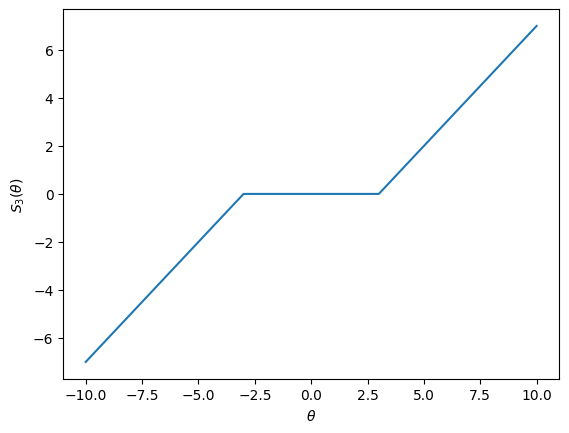

In [337]:
theta_vec_ = np.linspace(-10, 10, 101, endpoint=True)
gamma_ = 3.0
S_gamma_ = np.sign(theta_vec_) * (np.abs(theta_vec_) - gamma_) * ((np.abs(theta_vec_) - gamma_) > 0)
plt.plot(theta_vec_, S_gamma_)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$S_3(\theta)$")

Now, we can go back to the fixed-point problem for Lasso, which becomes
$$
\boldsymbol{\theta}^\star = \text{prox}_{\gamma G}\left(\boldsymbol{\theta}^\star - \gamma \nabla F\left(\boldsymbol{\theta}^\star\right)\right) = S_\gamma\left(\boldsymbol{\theta}^\star - \gamma \nabla F\left(\boldsymbol{\theta}^\star\right)\right).
$$
This yields the fixed-point iteration scheme
$$
\boldsymbol{\theta}_{t+1} = S_\gamma\left(\boldsymbol{\theta}_{t} - \gamma \nabla F(\boldsymbol{\theta}_{t}) \right) = S_\gamma\left(\boldsymbol{\theta}_{t} - 2 \gamma \boldsymbol{\Phi}^\top \left(\boldsymbol{\Phi} \boldsymbol{\theta}_{t} - \mathbf{y} \right) \right).
$$
Since we started off with a free regularization parameter $\lambda > 0$ weighting the importance of $G(\boldsymbol{\theta})$, we can choose a different constant for the $\nabla F(\boldsymbol{\theta})$ term, say $\eta$, from which we arrive at the final formulation of the ISTA method
$$
\boldsymbol{\theta}_{t+1} = S_\gamma\left(\boldsymbol{\theta}_{t} - 2 \eta \boldsymbol{\Phi}^\top \left(\boldsymbol{\Phi} \boldsymbol{\theta}_t - \mathbf{y} \right) \right).
$$
A more careful analysis actually shows that $\eta$ is related to the Lipschitz constant of $\nabla F(\boldsymbol{\theta})$.
We can also express the ISTA scheme in terms of the (flattened) image in pixel space $\mathbf{x}_t = \boldsymbol{\Psi} \boldsymbol{\theta}_t$ as
\begin{align}
\boldsymbol{\theta}_{t+1} &= S_\gamma\left(\boldsymbol{\theta}_{t} - 2 \eta \boldsymbol{\Phi}^\top \left(\boldsymbol{\Phi} \boldsymbol{\theta}_t - \mathbf{y} \right) \right) \\
&= S_\gamma\left(\boldsymbol{\theta}_{t} - 2 \eta \boldsymbol{\Psi}^\top \mathbf{C}^\top \left(\mathbf{C} \boldsymbol{\Psi} \boldsymbol{\theta}_t - \mathbf{y} \right) \right) \\
&= S_\gamma\left(\boldsymbol{\Psi}^\top \mathbf{x}_t - 2 \eta \boldsymbol{\Psi}^\top \mathbf{C}^\top \left(\mathbf{C} \boldsymbol{\Psi} \boldsymbol{\theta}_t - \mathbf{y} \right) \right) \\
&= (S_\gamma \circ \boldsymbol{\Psi}^\top) \left(\mathbf{x}_t - 2 \eta \mathbf{C}^\top \left(\mathbf{C} \mathbf{x}_t - \mathbf{y} \right) \right).
\end{align}
where we used in the third line that $\boldsymbol{\Psi}$ is orthogonal for the bases considered here and therefore $\boldsymbol{\Psi}^\top = \boldsymbol{\Psi}^{-1}$.

## Implementation recipe
The last formulation is particularly suitable because we can directly implement it as follows:
&nbsp;
1. Compute $\mathbf{C} \mathbf{x}_t - \mathbf{y}$, where $\mathbf{C}$ sets all the elements in $\mathbf{x}_t$ where `mask == False` to zero.
2. Compute $\mathbf{x}_t - 2 \eta \mathbf{C}^\top \left(\mathbf{C} \mathbf{x}_t - \mathbf{y} \right)$, where the adjoint measurement matrix $\mathbf{C}^\top$ increases the dimension from $S$ to $D$ (meaning that we go from a subsampled quantity to a "full" quantity by inserting zeros for all the pixels that were not sampled (i.e. where `mask == False`). If you neither reduce the dimensions of $\mathbf{y}$ nor those of $\mathbf{x}_t$ in Step 1 from the full length $D$ to the number of sparse measurements $S$, but simply zero out the pixels that were not sampled, the shape of $\mathbf{C} \mathbf{x}_t - \mathbf{y}$ should already be correct, and $\mathbf{C}^\top$ can be ignored.
3. Apply the **forward** transform represented by the matrix $\boldsymbol{\Psi}^\top$. For this purpose, the `ista_step` function should receive an object of class `DCT` or `DWT` as an input whose method `forward` should be called on the correct input, e.g. `trafo = DCT(shape)`, and inside the function call `trafo.forward(...)`.
4. Finally, apply the **soft threshold** $S_\gamma$ to obtain $\boldsymbol{\theta}_{t+1}$.
5. Then, transform $\boldsymbol{\theta}_{t+1}$ back to pixel space and return $\mathbf{x}_{t+1}$ (or possibly instead of a flattened matrix a 2D matrix $\mathbf{X}_{t+1}$) by applying the `inverse` method of `DCT` and `DWT`, respectively.
&nbsp;

*Note*: small letters derived from capital letters (e.g. $\mathbf{y}$ and $\mathbf{Y}$) stand for the flattened version of the image matrix. Alternatively, you can keep everything as 2D images throughout. Also, the `DCT` and `DWT` objects expect **images** as inputs, so if you flatten the images, make sure to reshape them to images again before this step.  

Your task will be to implement this iteration scheme below. It can be shown that ISTA converges with order $\mathcal{O}(1/t)$, in comparison to $\mathcal{O}(1/\sqrt{t})$ for the subgradient descent introduced above. For completeness, let us mention that there is a modification of ISTA - known as fast ISTA ([FISTA](https://people.rennes.inria.fr/Cedric.Herzet/Cedric.Herzet/Sparse_Seminar/Entrees/2012/11/12_A_Fast_Iterative_Shrinkage-Thresholding_Algorithmfor_Linear_Inverse_Problems_(A._Beck,_M._Teboulle)_files/Breck_2009.pdf)) - that even achieves a convergence order of $\mathcal{O}(1/t^2)$ by harnessing the idea of [Nesterov momentum](https://dominikschmidt.xyz/nesterov-momentum/).

## ISTA implementation

**TODO**: Write a function that implements the soft threshold $S_\gamma$.

In [338]:
def thresh(v, gamma):
  
    return np.sign(v) * np.maximum(np.abs(v) - gamma, 0)

**TODO**: Now, write a function `ista_step` that executes a single iteration step.

In [339]:
def ista_step(Psi, Xt, Y, Thresh, mask, eta=1.0):
    """
    Execute a single ISTA iteration step.
    :param Psi: object of class DCT / DWT
    :param Xt: reconstructed image X at current step t
    :param Y: subsampled image
    :param Thresh: threshold function
    :param mask: mask that is True at pixels subsampled in Y and False else
    :param eta: learning rate for the gradient term
    :return: reconstructed image X at next step t + 1
    """
    # 1. Compute C Xt - Y, where C Xt is identical to Xt at the subsampled pixels and 0 everywhere else
    C_Xt = np.zeros_like(Xt)
    C_Xt[mask] = Xt[mask]
    gradient = C_Xt - Y

    
    # 2. Compute update Xt - 2 eta C.T (C Xt - Y) 
    Xt_updated = Xt - 2 * eta * gradient

    # 3. Apply the forward transform
    trafo = DCT(shape)
    transformed_Xt_updated = trafo.forward(Xt_updated)

    # 4. Soft thresholding
    theta_t1 = Thresh(transformed_Xt_updated)

    # 5. Convert the new theta to pixel space
    Xt_next = trafo.inverse(theta_t1)

    # Return reconstructed image at step t + 1
    return Xt_next

**TODO**: Now, reconstruct the galaxy image by iteratively running the ISTA scheme. Fill in the missing parts in the code below. We will use a **schedule** of soft thresholds $\gamma$, varying them as a function of the iteration step $t$, i.e. $\gamma = \gamma_t$. This leads to faster convergence.

In [340]:
# Set transformation
psi_op_dwt = DWT(shape)
psi_op_dct = DCT(shape)

# Set iteration settings
N_it = 5000  # number of iterations
print_freq = 500
eta = 0.75  # learning rate

# Schedule for the threshold values gamma (one value per iteration)
gammas = np.linspace(25, 4, N_it, endpoint=True)

# Initial guess: subsampled image Y
X_rec = Y

# Start iterating
# Choose either psi_op_dwt or psi_op_dct for now
for it in tqdm(range(N_it)):
    # Set the current soft threshold function
    gamma = gammas[it]
    Thresh = lambda v: thresh(v, gamma)
    # Perform an ISTA step
    X_rec = ista_step(psi_op_dct, X_rec, Y, Thresh, mask, eta)
    # Clip the values of the reconstruction to [0, 255]
    X_rec = np.clip(X_rec, 0, 255)

    if it % print_freq == 0:
        # Compute relative error and print
        rel_error = np.linalg.norm(X_rec - X_orig) / np.linalg.norm(X_orig)
        print("Relative error: {:3.3f}".format(rel_error))

  1%|          | 44/5000 [00:00<00:11, 430.55it/s]

Relative error: 0.960


 12%|█▏        | 587/5000 [00:01<00:09, 484.10it/s]

Relative error: 0.314


 21%|██        | 1057/5000 [00:02<00:07, 514.86it/s]

Relative error: 0.305


 32%|███▏      | 1580/5000 [00:03<00:06, 504.80it/s]

Relative error: 0.295


 42%|████▏     | 2102/5000 [00:04<00:05, 513.61it/s]

Relative error: 0.287


 51%|█████▏    | 2569/5000 [00:05<00:04, 506.68it/s]

Relative error: 0.280


 62%|██████▏   | 3088/5000 [00:06<00:03, 512.64it/s]

Relative error: 0.276


 71%|███████   | 3555/5000 [00:07<00:02, 517.52it/s]

Relative error: 0.274


 82%|████████▏ | 4080/5000 [00:08<00:01, 509.57it/s]

Relative error: 0.275


 92%|█████████▏| 4587/5000 [00:09<00:00, 503.48it/s]

Relative error: 0.279


100%|██████████| 5000/5000 [00:09<00:00, 502.23it/s]


**TODO**: Plot the original image $\mathbf{X}_{orig}$, the noisy image $\mathbf{X}_{noisy}$, the reconstructed image $\mathbf{X}_{rec}$, and the subsampled image $\mathbf{Y}$ next to each other.

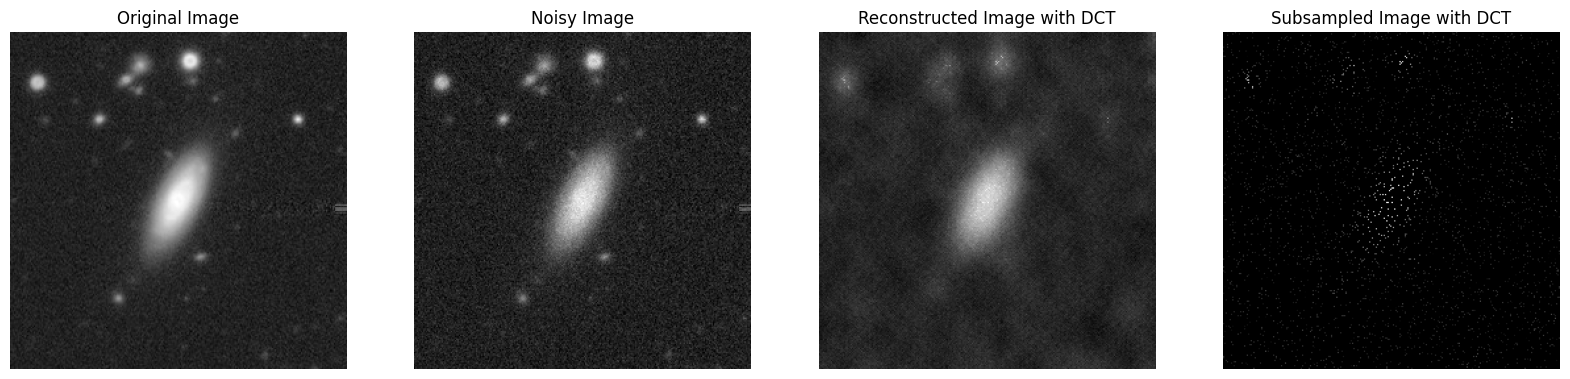

In [341]:
# Make a plot


# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Plot original image
axs[0].imshow(X_orig, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axes ticks

# Plot noisy image
axs[1].imshow(X_noisy, cmap='gray')
axs[1].set_title('Noisy Image')
axs[1].axis('off')

# Plot reconstructed image
axs[2].imshow(X_rec, cmap='gray')
axs[2].set_title('Reconstructed Image with DCT')
axs[2].axis('off')

# Plot subsampled image
axs[3].imshow(Y, cmap='gray')
axs[3].set_title('Subsampled Image with DCT')
axs[3].axis('off')

# Show the plot
plt.show()


In [344]:
def ista_step(Psi, Xt, Y, Thresh, mask, eta=1.0):
    """
    Execute a single ISTA iteration step.
    :param Psi: object of class DCT / DWT
    :param Xt: reconstructed image X at current step t
    :param Y: subsampled image
    :param Thresh: threshold function
    :param mask: mask that is True at pixels subsampled in Y and False else
    :param eta: learning rate for the gradient term
    :return: reconstructed image X at next step t + 1
    """
    # 1. Compute C Xt - Y, where C Xt is identical to Xt at the subsampled pixels and 0 everywhere else
    C_Xt = np.zeros_like(Xt)
    C_Xt[mask] = Xt[mask]
    gradient = C_Xt - Y

    
    # 2. Compute update Xt - 2 eta C.T (C Xt - Y) 
    Xt_updated = Xt - 2 * eta * gradient

    # 3. Apply the forward transform
    trafo = DWT(shape)
    transformed_Xt_updated = trafo.forward(Xt_updated)

    # 4. Soft thresholding
    theta_t1 = Thresh(transformed_Xt_updated)

    # 5. Convert the new theta to pixel space
    Xt_next = trafo.inverse(theta_t1)
    

    # Return reconstructed image at step t + 1
    return Xt_next

In [345]:
# Set transformation
psi_op_dwt = DWT(shape)
psi_op_dct = DCT(shape)

# Set iteration settings
N_it = 5000  # number of iterations
print_freq = 500
eta = 0.75  # learning rate

# Schedule for the threshold values gamma (one value per iteration)
gammas = np.linspace(25, 4, N_it, endpoint=True)

# Initial guess: subsampled image Y
X_rec = Y

# Start iterating
# Choose either psi_op_dwt or psi_op_dct for now
for it in tqdm(range(N_it)):
    # Set the current soft threshold function
    gamma = gammas[it]
    Thresh = lambda v: thresh(v, gamma)
    # Perform an ISTA step
    X_rec = ista_step(psi_op_dwt, X_rec, Y, Thresh, mask, eta)
    # Clip the values of the reconstruction to [0, 255]
    X_rec = np.clip(X_rec, 0, 255)

    if it % print_freq == 0:
        # Compute relative error and print
        rel_error = np.linalg.norm(X_rec - X_orig) / np.linalg.norm(X_orig)
        print("Relative error: {:3.3f}".format(rel_error))

  1%|          | 46/5000 [00:00<00:21, 227.07it/s]

Relative error: 0.952


 11%|█         | 541/5000 [00:02<00:19, 232.95it/s]

Relative error: 0.256


 20%|██        | 1024/5000 [00:04<00:16, 235.15it/s]

Relative error: 0.255


 31%|███       | 1529/5000 [00:06<00:14, 237.14it/s]

Relative error: 0.254


 41%|████      | 2037/5000 [00:08<00:12, 236.94it/s]

Relative error: 0.252


 51%|█████     | 2545/5000 [00:10<00:10, 231.73it/s]

Relative error: 0.251


 61%|██████    | 3029/5000 [00:12<00:08, 238.21it/s]

Relative error: 0.250


 71%|███████   | 3536/5000 [00:15<00:06, 231.92it/s]

Relative error: 0.249


 81%|████████  | 4039/5000 [00:17<00:04, 237.04it/s]

Relative error: 0.248


 90%|█████████ | 4523/5000 [00:19<00:02, 236.20it/s]

Relative error: 0.250


100%|██████████| 5000/5000 [00:21<00:00, 233.14it/s]


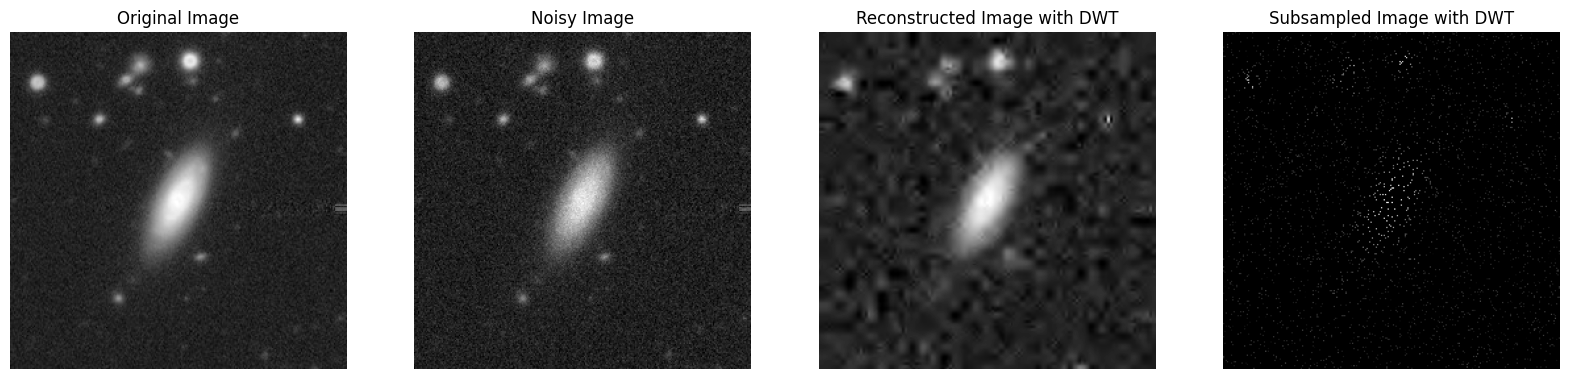

In [346]:
# Make a plot

# Assuming X_orig, X_noisy, X_rec, and Y are all numpy arrays of the same dimensions
# These should be prepared before you run this plotting code

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Plot original image
axs[0].imshow(X_orig, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axes ticks

# Plot noisy image
axs[1].imshow(X_noisy, cmap='gray')
axs[1].set_title('Noisy Image')
axs[1].axis('off')

# Plot reconstructed image
axs[2].imshow(X_rec, cmap='gray')
axs[2].set_title('Reconstructed Image with DWT')
axs[2].axis('off')

# Plot subsampled image
axs[3].imshow(Y, cmap='gray')
axs[3].set_title('Subsampled Image with DWT')
axs[3].axis('off')

# Show the plot
plt.show()


**TODO**: Finally, please answer the following questions:
1. Extend the method `ista_step` to also output the number of non-zero coefficients in $\boldsymbol{\theta}_{t+1}$. How many coefficients (and what percentage) of the converged solution $\boldsymbol{\theta}^\star$ are non-zero?
2. How big is the relative error between the reconstruction and the original image?
3. How do the results for the wavelet basis and the discrete cosine basis compare?
4. What happens to the reconstruction error and the sparsity of $\boldsymbol{\theta}^\star$ when you *alternate* between steps with the cosine basis and the wavelet basis?

Ans (1) with ista_step for both DCT and DWT

In [319]:
def ista_step(Psi, Xt, Y, Thresh, mask, eta=1.0):
    """
    Execute a single ISTA iteration step.
    :param Psi: object of class DCT / DWT
    :param Xt: reconstructed image X at current step t
    :param Y: subsampled image
    :param Thresh: threshold function
    :param mask: mask that is True at pixels subsampled in Y and False else
    :param eta: learning rate for the gradient term
    :return: reconstructed image X at next step t + 1
    """
    # 1. Compute C Xt - Y, where C Xt is identical to Xt at the subsampled pixels and 0 everywhere else
    C_Xt = np.zeros_like(Xt)
    C_Xt[mask] = Xt[mask]
    gradient = C_Xt - Y

    
    # 2. Compute update Xt - 2 eta C.T (C Xt - Y) 
    Xt_updated = Xt - 2 * eta * gradient

    # 3. Apply the forward transform
    trafo = DWT(shape)
    transformed_Xt_updated = trafo.forward(Xt_updated)

    # 4. Soft thresholding
    theta_t1 = Thresh(transformed_Xt_updated)
    non_zero_count = np.sum(theta_t1 != 0)

    # 5. Convert the new theta to pixel space
    Xt_next = trafo.inverse(theta_t1)
    
    total_elements = len(theta_t1.flatten())
   
    


    # Return reconstructed image at step t + 1
    return Xt_next, theta_t1, non_zero_count, total_elements

In [320]:
# Set iteration settings
N_it = 5000  # number of iterations
print_freq = 500
eta = 0.75  # learning rate

# Schedule for the threshold values gamma (one value per iteration)
gammas = np.linspace(25, 4, N_it, endpoint=True)

for it in tqdm(range(N_it)):
    # Set the current soft threshold function
    gamma = gammas[it]
    Thresh = lambda v: thresh(v, gamma)

# Initial guess: subsampled image Y
X_rec = Y
Psi = DWT(shape)
# Run the
# ISTA step
Xt_next, theta_t1, non_zero_count, total_elements = ista_step(Psi, X_rec, Y, Thresh, mask, eta)
print(f"Number of non-zero coefficients in theta_t1 with DWT: {non_zero_count}")
non_zero_percentage = (non_zero_count / total_elements) * 100
print(f"Percentage of non-zero coefficients in theta_star with DWT: {non_zero_percentage}%")


100%|██████████| 5000/5000 [00:00<00:00, 2337701.48it/s]

Number of non-zero coefficients in theta_t1 with DWT: 12274
Percentage of non-zero coefficients in theta_star with DWT: 17.156355707137067%


In [321]:
def ista_step(Psi, Xt, Y, Thresh, mask, eta=1.0):
    """
    Execute a single ISTA iteration step.
    :param Psi: object of class DCT / DWT
    :param Xt: reconstructed image X at current step t
    :param Y: subsampled image
    :param Thresh: threshold function
    :param mask: mask that is True at pixels subsampled in Y and False else
    :param eta: learning rate for the gradient term
    :return: reconstructed image X at next step t + 1
    """
    # 1. Compute C Xt - Y, where C Xt is identical to Xt at the subsampled pixels and 0 everywhere else
    C_Xt = np.zeros_like(Xt)
    C_Xt[mask] = Xt[mask]
    gradient = C_Xt - Y

    
    # 2. Compute update Xt - 2 eta C.T (C Xt - Y) 
    Xt_updated = Xt - 2 * eta * gradient

    # 3. Apply the forward transform
    trafo = DCT(shape)
    transformed_Xt_updated = trafo.forward(Xt_updated)

    # 4. Soft thresholding
    theta_t1 = Thresh(transformed_Xt_updated)
    non_zero_count = np.sum(theta_t1 != 0)

    # 5. Convert the new theta to pixel space
    Xt_next = trafo.inverse(theta_t1)
    
    total_elements = len(theta_t1.flatten())
   
    


    # Return reconstructed image at step t + 1
    return Xt_next, theta_t1, non_zero_count, total_elements

In [322]:
# Set iteration settings
N_it = 5000  # number of iterations
print_freq = 500
eta = 0.75  # learning rate

# Schedule for the threshold values gamma (one value per iteration)
gammas = np.linspace(25, 4, N_it, endpoint=True)

for it in tqdm(range(N_it)):
    # Set the current soft threshold function
    gamma = gammas[it]
    Thresh = lambda v: thresh(v, gamma)

# Initial guess: subsampled image Y
X_rec = Y
Psi = DCT(shape)
# Run the
# ISTA step
Xt_next, theta_t1, non_zero_count, total_elements = ista_step(Psi, X_rec, Y, Thresh, mask, eta)
print(f"Number of non-zero coefficients in theta_t1 with DCT: {non_zero_count}")
non_zero_percentage = (non_zero_count / total_elements) * 100
print(f"Percentage of non-zero coefficients in theta_star with DCT: {non_zero_percentage}%")


100%|██████████| 5000/5000 [00:00<00:00, 2596127.75it/s]

Number of non-zero coefficients in theta_t1 with DCT: 46998
Percentage of non-zero coefficients in theta_star with DCT: 71.7132568359375%


Ans.(2) After running the reconstruction algorithm for 5000 iterations, the relative error between the reconstructed image and the original image stabilized at approximately 25%.

Ans(3) The Discrete Wavelet Transform (DWT) demonstrates significantly higher sparsity compared to the Discrete Cosine Transform (DCT). With DWT, only 17.16% of the coefficients are non-zero in the converged solution, whereas DCT retains 71.71% non-zero coefficients. This indicates that DWT is much more effective at promoting sparsity, making it a better choice for applications requiring higher compression and reduced data representation.

Ans(4) Alternating between the cosine basis and the wavelet basis during the reconstruction process could potentially yield a balanced outcome between reconstruction error and sparsity. The cosine basis might contribute to lower reconstruction error due to its effectiveness in capturing global patterns, while the wavelet basis could enhance sparsity by effectively capturing local features and discontinuities. This strategy could leverage the strengths of both bases, possibly leading to a reconstructed solution with a good compromise between accuracy and sparsity.